In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
from matplotlib import font_manager,rc  #한글 폰트 입력을 위한 라이브러리

#폰트 경로 가져오기
# font_path = 'C:/Users/smcljy/AppData/Local/Microsoft/Windows/Fonts/.ttf'
font_path = 'C:/Windows/Fonts/SGL.ttf' #삼성고딕체
 
# 폰트 이름 얻어오기
font_name = font_manager.FontProperties(fname=font_path).get_name()
 
#폰트 설정하기
mpl.rc('font',family=font_name)

In [19]:
workdir = "C:/Users/smcljy/data/20211115_Factsheet"
file_path = '{}/NUM_DATA.dta'.format(workdir)

data = pd.read_stata(file_path)

# data = pd.merge(data1,data2, on=['ID','ORDR_YMD'], how="left")

# 조건별 그룹 설정

### 정상, 기타 결과 그룹 분리

In [20]:
GRP = 'DYSLIPID'

In [21]:
data.loc[(data['BL3113'] >= 240) | (data['BL314201'] >= 160 ) | (data['BL3141'] >= 200 ) | (data['BL3142'] < 40 ) | (data['TRT_MED_HYPERLIPIDEMIA'] == '1'), GRP] = '이상지질혈증'
# data.loc[(data['BL3164'] >= 6.5) | (data['TRT_MED_DIABETES'] == '1'), GRP] = '당뇨'
data['DYSLIPID'].fillna('정상',inplace=True)

In [22]:
data.loc[data['GEND_CD'] == 'M', 'GENDER'] = '남'
data.loc[data['GEND_CD'] == 'F', 'GENDER'] = '여'

In [23]:
data.loc[ data['AGE'] < 30                      ,'AGEGRP'] = '0~29세'
data.loc[(data['AGE'] > 29) & (data['AGE'] < 40),'AGEGRP'] = '30~39세'
data.loc[(data['AGE'] > 39) & (data['AGE'] < 50),'AGEGRP'] = '40~49세'
data.loc[(data['AGE'] > 49) & (data['AGE'] < 60),'AGEGRP'] = '50~59세'
data.loc[(data['AGE'] > 59) & (data['AGE'] < 70),'AGEGRP'] = '60~69세'
data.loc[ data['AGE'] > 69                      ,'AGEGRP'] = '70세 이상'
# data.head(100)

### 특정 그룹 별도 저장 - 이상지질혈증(Dyslipidemia)은 control군 배제

In [24]:
# dysl_ctrl = data.drop(data.loc[data[GRP]!='당뇨'].index)
# dysl_ctrl.loc[(dysl_ctrl['BL3164'] < 7.0), '{}_CTRL_YN'.format(GRP)] = '조절군'
# dysl_ctrl['{}_CTRL_YN'.format(GRP)].fillna('비조절군',inplace=True)
# dysl_ctrl

In [25]:
data_m = data.drop(data.loc[data['GEND_CD']=='F'].index)
data_f = data.drop(data.loc[data['GEND_CD']=='M'].index)

In [26]:
# data_ctrl_m = dysl_ctrl.drop(dysl_ctrl.loc[dysl_ctrl['GEND_CD']=='F'].index)
# data_ctrl_f = dysl_ctrl.drop(dysl_ctrl.loc[dysl_ctrl['GEND_CD']=='M'].index)

## pivot table create

In [27]:
dysl_cnt_m = data_m.pivot_table(
                             index=[GRP,'GENDER']
                            ,columns=['AGEGRP']
    ,values=['ID']
    ,aggfunc='count'
    ,margins=True
    ,fill_value=0
                            )

# dysl_cnt_m
# dysl_per_m = round(dysl_cnt_m.div(dysl_cnt_m.iloc[-1,-1], axis=0).astype(float)*100,1) # total value
# each column total value percentile
dysl_per_m = round(dysl_cnt_m.div(dysl_cnt_m.iloc[-1], axis=1).astype(float)*100,1)

# dysl_per_m

dysl_agegrp_m = pd.DataFrame()

for i in range(len(dysl_cnt_m.columns)):
    if i == 0:
        dysl_agegrp_m = pd.concat(
                                [
                                 dysl_cnt_m.iloc[:,i]
                                ,dysl_per_m.iloc[:,i]
                                ]
                            ,axis=1
        )
    else:
        dysl_agegrp_m = pd.concat(
                                [
                                 dysl_agegrp_m
                                ,dysl_cnt_m.iloc[:,i]
                                ,dysl_per_m.iloc[:,i]
                                ]
                            ,axis=1
        )
        
# dysl_agegrp_m

In [28]:
dysl_cnt_f = data_f.pivot_table(
                             index=[GRP,'GENDER']
                            ,columns=['AGEGRP']
    ,values=['ID']
    ,aggfunc='count'
    ,margins=True
    ,fill_value=0
                            )

# dysl_cnt_f
# dysl_per_f = round(dysl_cnt_f.div(dysl_cnt_f.iloc[-1,-1], axis=0).astype(float)*100,1) # total value
# each column total value percentile
dysl_per_f = round(dysl_cnt_f.div(dysl_cnt_f.iloc[-1], axis=1).astype(float)*100,1)

# dysl_per_f

dysl_agegrp_f = pd.DataFrame()

for i in range(len(dysl_cnt_f.columns)):
    if i == 0:
        dysl_agegrp_f = pd.concat(
                                [
                                 dysl_cnt_f.iloc[:,i]
                                ,dysl_per_f.iloc[:,i]
                                ]
                            ,axis=1
        )
    else:
        dysl_agegrp_f = pd.concat(
                                [
                                 dysl_agegrp_f
                                ,dysl_cnt_f.iloc[:,i]
                                ,dysl_per_f.iloc[:,i]
                                ]
                            ,axis=1
        )
        
# dysl_agegrp_f

In [29]:
dysl_agegrp = pd.concat([dysl_agegrp_m.iloc[:-1,:], dysl_agegrp_f.iloc[:-1,:]],axis=0)
# dysl_agegrp = pd.concat([dysl_agegrp_m, dysl_agegrp_f],axis=0)
dysl_agegrp_label = []

for i in range(len(dysl_agegrp.columns)):
    dysl_agegrp_label.append(dysl_agegrp.columns[i][1])
    
dysl_agegrp.columns = dysl_agegrp_label
# dysl_agegrp.set_index(dysl_agegrp.index.names,inplace=True)
dysl_agegrp = dysl_agegrp.sort_index()

labels = []
for i in range(len(dysl_per_m.columns)-1):
    labels.append(dysl_per_m.columns[i][1])
    
# dysl_agegrp

In [30]:
dysl_cnt_t = data.pivot_table(
                             index=[GRP]#,'GENDER']
                            ,columns=['AGEGRP']
    ,values=['ID']
    ,aggfunc='count'
    ,margins=True
    ,fill_value=0
                            )

# total value percentile
dysl_per_t = round(dysl_cnt_t.div(dysl_cnt_t.iloc[-1,-1], axis=0).astype(float)*100,1)

dysl_per_t

dysl_agegrp_t = pd.DataFrame()

for i in range(len(dysl_cnt_t.columns)):
    if i == 0:
        dysl_agegrp_t = pd.concat(
                                [
                                 dysl_cnt_t.iloc[:,i]
                                ,dysl_per_t.iloc[:,i]
                                ]
                            ,axis=1
        )
    else:
        dysl_agegrp_t = pd.concat(
                                [
                                 dysl_agegrp_t
                                ,dysl_cnt_t.iloc[:,i]
                                ,dysl_per_t.iloc[:,i]
                                ]
                            ,axis=1
        )

# dysl_agegrp_t

# Bar chart create

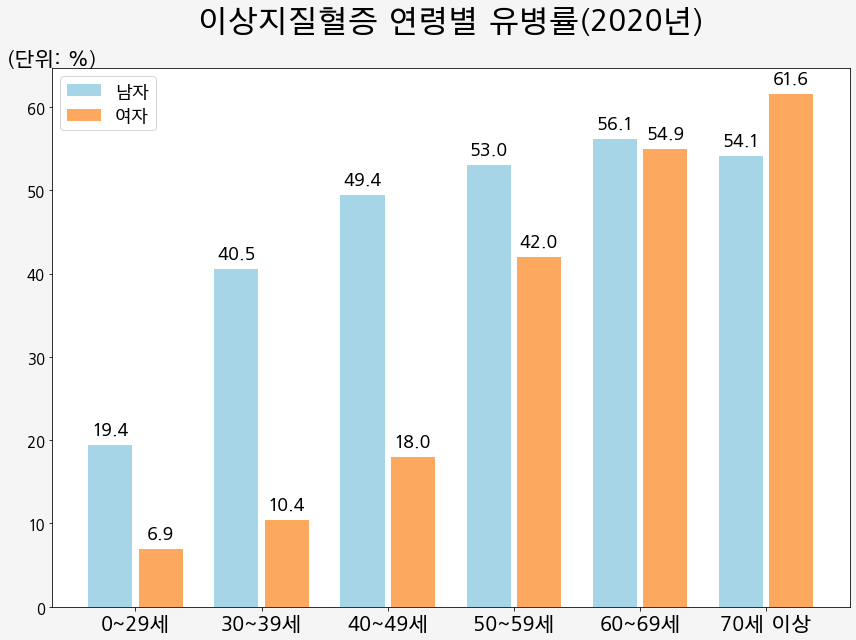

In [31]:
value01 = dysl_per_m.iloc[0,:-1]
value02 = dysl_per_f.iloc[0,:-1]

x = np.arange(len(labels))  # the label locations # all 값이 list에는 포함되지 않았기 때문임.
width = 0.35  # the width of the bars

# fig, ax = plt.subplots()
fig, ax = plt.subplots(figsize=(12, 9)) # 캔버스 배경 사이즈 설정

fig.set_facecolor('whitesmoke') ## 캔버스 배경색 설정
rects1 = ax.bar(x - 0.2, value01, width, label='남자',color=plt.get_cmap('RdYlBu')(np.linspace(0.15, 0.85,np.array(dysl_per_m.iloc[0,:-1]).shape[0]))[4])
rects2 = ax.bar(x + 0.2, value02, width, label='여자',color=plt.get_cmap('RdYlBu')(np.linspace(0.15, 0.85,np.array(dysl_per_m.iloc[0,:-1]).shape[0]))[1])

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_title('이상지질혈증 연령별 유병률(2020년)\n',fontsize=30)
ax.set_ylabel(
                '(단위: %)' # 표시값
                 ,labelpad=-70 # 여백값 설정
                ,fontsize=20 # 글씨크기 설정
                ,rotation=0 # 회전값 조정
#                 ,ha='center' # 위치조정
                ,loc='top' # 위치조정, ha와 동시에 사용은 불가함.
            )
ax.yaxis.set_tick_params(labelsize=15) # y축 표시값 글씨크기 조정
ax.set_xticks(x)
ax.set_xticklabels(
                   labels[0:len(labels)] # all 값이 list에는 포함되지 않았기 때문임.
                  , fontsize=20
                  )
ax.legend(fontsize=17)

# bar위에 값 label 표시
def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate(height, 
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 8),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom'
                   ,fontsize=18
                   )

# autolabel(rects1)
autolabel(rects1)
autolabel(rects2)
# autolabel(rects3)

fig.tight_layout()

plt.savefig("{}/dysl_total_mf.png".format(workdir),edgecolor="black")

# plt.show()

No handles with labels found to put in legend.


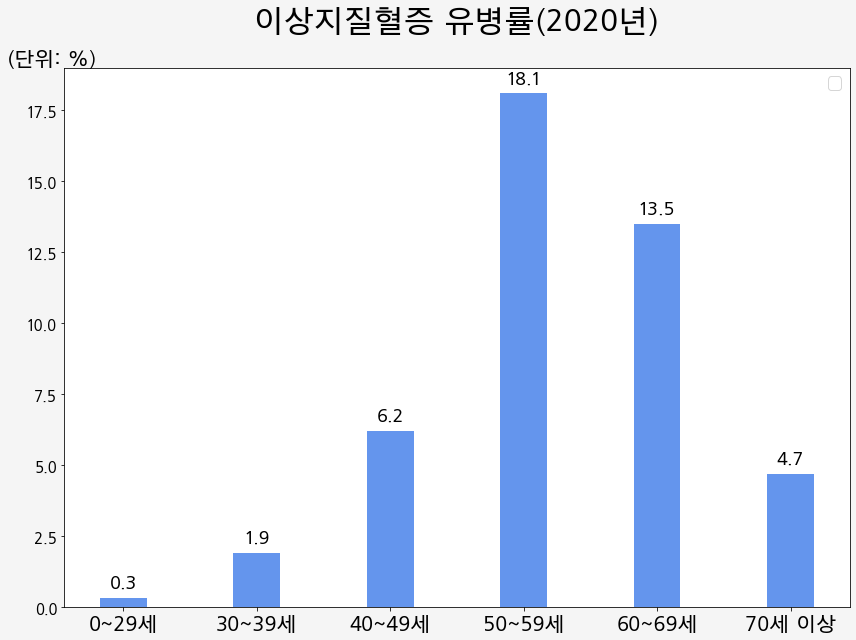

In [32]:
value01 = dysl_per_t.iloc[0,:-1]
# value02 = dysl_hdysl_per_m[2:-1]
# value03 = dysl_hdysl_per_f[2:-1]

x = np.arange(len(labels))  # the label locations # all 값이 list에는 포함되지 않았기 때문임.
width = 0.35  # the width of the bars

# fig, ax = plt.subplots()
fig, ax = plt.subplots(figsize=(12, 9)) # 캔버스 배경 사이즈 설정

fig.set_facecolor('whitesmoke') ## 캔버스 배경색 설정
# rects1 = ax.bar(x,  value01, width, label='전체',color='cornflowerblue')
rects1 = ax.bar(x,  value01, width,color='cornflowerblue')
# rects2 = ax.bar(x - 0.2, value02, width, label='남자',color=plt.get_cmap('RdYlBu')(np.linspace(0.15, 0.85,np.array(dysl_hdysl_per_t[2:-1]).shape[0]))[4])
# rects3 = ax.bar(x + 0.2, value03, width, label='여자',color=plt.get_cmap('RdYlBu')(np.linspace(0.15, 0.85,np.array(dysl_hdysl_per_t[2:-1]).shape[0]))[1])

# rects1 = ax.bar(x - width-0.05, value01, width, label='전체',color=plt.get_cmap('gist_ncar')(np.linspace(0.15, 0.85,np.array(dysl_dysl_per_t).shape[0]))[1][2])
# rects2 = ax.bar(x             , value02, width, label='남자',color=plt.get_cmap('gist_ncar')(np.linspace(0.15, 0.85,np.array(dysl_dysl_per_t).shape[0]))[2][2])
# rects3 = ax.bar(x + width+0.05, value03, width, label='여자',color=plt.get_cmap('gist_ncar')(np.linspace(0.15, 0.85,np.array(dysl_dysl_per_t).shape[0]))[3][2])

# 3개 이상 표시를 하고 싶다면 아래와 같이
# 문제는 x - width가 표시할 bar의 위치를 지정하는 것
# fig, ax = plt.subplots()
# rects1 = ax.bar(x - width/3, value_m, width, label='Men')
# rects2 = ax.bar(x + width/3, value_f, width, label='Women')
# rects3 = ax.bar(x + width + width/3, value_t, width, label='Total')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_title('이상지질혈증 유병률(2020년)\n',fontsize=30)
ax.set_ylabel(
                '(단위: %)' # 표시값
                 ,labelpad=-70 # 여백값 설정
                ,fontsize=20 # 글씨크기 설정
                ,rotation=0 # 회전값 조정
#                 ,ha='center' # 위치조정
                ,loc='top' # 위치조정, ha와 동시에 사용은 불가함.
            )
ax.yaxis.set_tick_params(labelsize=15) # y축 표시값 글씨크기 조정
ax.set_xticks(x)
ax.set_xticklabels(
                   labels[0:len(labels)] # all 값이 list에는 포함되지 않았기 때문임.
                  , fontsize=20
                  )
ax.legend(fontsize=17)

# bar위에 값 label 표시
def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate(height, 
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 8),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom'
                   ,fontsize=18
                   )

autolabel(rects1)
# autolabel(rects2)
# autolabel(rects3)
# autolabel(rects3)

fig.tight_layout()

plt.savefig("{}/dysl_total_t.png".format(workdir),edgecolor="black")

# plt.show()

# data merge, export

In [33]:
dysl_agegrp.to_excel('{}/dysl_agegrp.xlsx'.format(workdir))
dysl_agegrp_t.to_excel('{}/dysl_agegrp_t.xlsx'.format(workdir))